In [6]:
#setup
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSBSSSBB'
meas='SNWD'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [7]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [8]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [10]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [11]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+--------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|              res_2|              res_3|res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+--------+-----------+---------+------+--------------------+------+
|-0.4549278752870645|-0.5471123934084439|0.11881281322515094|     36.6|BSBSSSBB| 31.9297| -82.6792|       SNWD|0.6803987279924087|0.21814916712951682|0.19634949508390923|Infinity|USC00095386|      0.0|     0|[00 00 00 00 00 0...|1930.0|
|-0.4549278752870645|-0.5471123934084439|0.118812813

### Plot Mean and Eigenvecs

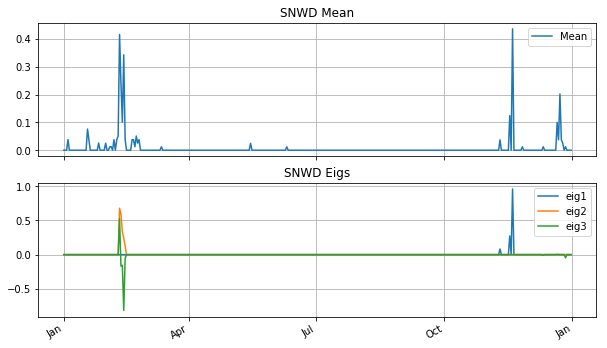

In [12]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

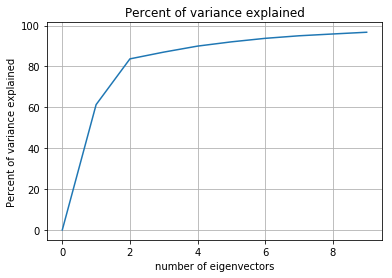

In [13]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [14]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

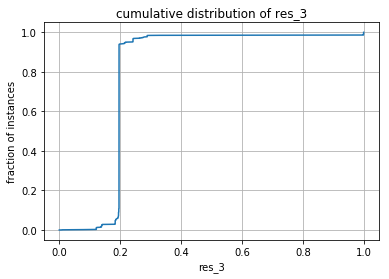

In [15]:
plot_CDF(df,'res_3')

In [16]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00095386', 1930.0)

In [17]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

32485

In [18]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [19]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [20]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00098351 16650
USW00093845 4690
USC00098228 364
USC00094429 19596
USC00092839 27693
US1GALN0001 338
USC00095811 12299
USC00090090 8877
USC00090006 363
USC00090670 2190
USC00096259 328
USC00093695 19778
USC00096126 15835
USW00013857 5324
USW00013870 20061
USC00098964 353
USC00095696 1426
USC00093325 8134
USC00095386 19791
USC00095401 3141
USC00092783 20627
USC00097777 17856
USC00095858 16896
USC00096237 9994
USC00098223 17237
USC00089640 3982
USC00094862 2533
USC00084393 362
USC00084394 21106
USC00093386 20065
USC00090131 9432
USC00092966 21014
USC00092844 365
USC00090053 9403
USC00096838 16945
USC00097171 4379
USC00094170 28421
USC00090010 21125
USC00099186 27201
USC00093465 22436
USC00094971 1089
USW00013861 5017
USC00082391 365
USC00094204 4742
USC00096879 365
USC00096244 7923
USC00085275 19115
USC00098974 8678
USC00093312 365
USC00095863 18362
USC00093460 20858
USC00092532 13345
USC00098972 5654
USC00099451 2548
USC00095874 21346
USC00095492 365
USC00098496 16351
USC00085099 2105

In [21]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(64, 32485)


In [22]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  1.37317843991
RMS removing mean-by-station=  1.3729093267
RMS removing mean-by-day   =  1.31110257563


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


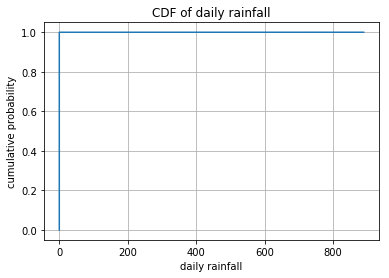

In [23]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [24]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [25]:
#USC00193270 21482
#USC00193702 28237
#USC00094238 1424
#USC00098351 3393
X=copy(All['USC00092783'])
Y=copy(All['USC00098351'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


20627
16650
15422
15422


In [26]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

m=15422,l=0,n1=2,n2=0,LogPval=-0.000000
(-1.887163173176871e-15, 15422)


### calculate the normalized log probability for each pair of stations.

In [27]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=336,l=0,n1=1,n2=1,LogPval=-0.000009
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=312,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=338,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  



m=0,l=0,n1=0,n2=0,LogPval=nan
m=8088,l=0,n1=0,n2=0,LogPval=0.000000
m=18533,l=1,n1=1,n2=1,LogPval=-0.000530
m=19691,l=0,n1=0,n2=0,LogPval=0.000000
m=20858,l=1,n1=1,n2=1,LogPval=-0.000477
m=19661,l=0,n1=1,n2=3,LogPval=-0.000000
m=19908,l=0,n1=1,n2=0,LogPval=0.000000
m=4358,l=0,n1=0,n2=1,LogPval=0.000000
m=18793,l=1,n1=1,n2=2,LogPval=-0.000487
m=14322,l=0,n1=1,n2=1,LogPval=-0.000000
m=2167,l=0,n1=0,n2=1,LogPval=0.000000
m=1089,l=0,n1=0,n2=0,LogPval=0.000000
m=20345,l=0,n1=1,n2=5,LogPval=-0.000000
m=12392,l=0,n1=1,n2=0,LogPval=-0.000000
m=3139,l=0,n1=0,n2=0,LogPval=0.000000
m=349,l=0,n1=0,n2=0,LogPval=0.000000
m=1416,l=0,n1=0,n2=2,LogPval=0.000000
m=12184,l=0,n1=1,n2=2,LogPval=-0.000000
m=15340,l=0,n1=1,n2=6,LogPval=-0.000000
m=18245,l=0,n1=1,n2=0,LogPval=0.000000
m=19797,l=0,n1=1,n2=11,LogPval=-0.000000
m=14321,l=0,n1=1,n2=0,LogPval=0.000000
m=9923,l=0,n1=0,n2=0,LogPval=0.000000
m=7904,l=0,n1=1,n2=0,LogPval=-0.000000
m=328,l=0,n1=0,n2=0,LogPval=0.000000
m=1746,l=0,n1=0,n2=0,LogPval=0.00

m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=8132,l=0,n1=0,n2=0,LogPval=0.000000
m=362,l=0,n1=0,n2=0,LogPval=0.000000
m=7938,l=0,n1=0,n2=0,LogPval=0.000000
m=8631,l=0,n1=0,n2=0,LogPval=0.000000
m=7930,l=0,n1=0,n2=0,LogPval=0.000000
m=7654,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=9268,l=0,n1=0,n2=0,LogPval=0.000000
m=9373,l=0,n1=0,n2=0,LogPval=0.000000
m=7054,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=6106,l=0,n1=0,n2=0,LogPval=0.000000
m=7545,l=0,n1=0,n2=0,LogPval=0.000000
m=9027,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=8361,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=9367,l=0,n1=0,n2=0,LogPval=0.000000
m=8642,l=0,n1=0,n2=0,LogPval=0.000000
m=9374,l=0,n1=0,n2=0,LogPval=0.000000
m=6803,l=0,n1=0,n2=1,LogPval=0.000000
m=9412,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=6115,l=0,n1=0,n2=0,LogPval=0.000000
m=2892,l=0,

m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=363,l=0,n1=0,n2=0,LogPval=0.000000
m=361,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=359,l=0,n1=0,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=353,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPv

m=4310,l=0,n1=1,n2=0,LogPval=0.000000
m=2448,l=0,n1=0,n2=0,LogPval=0.000000
m=4286,l=0,n1=0,n2=0,LogPval=0.000000
m=4712,l=0,n1=1,n2=0,LogPval=0.000000
m=4359,l=1,n1=1,n2=2,LogPval=-0.001763
m=4267,l=0,n1=1,n2=0,LogPval=0.000000
m=4376,l=0,n1=1,n2=0,LogPval=0.000000
m=3620,l=0,n1=0,n2=0,LogPval=0.000000
m=2182,l=1,n1=1,n2=1,LogPval=-0.003523
m=1087,l=0,n1=0,n2=0,LogPval=0.000000
m=4703,l=1,n1=1,n2=3,LogPval=-0.001564
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=3138,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1460,l=0,n1=1,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=3949,l=0,n1=1,n2=0,LogPval=0.000000
m=4328,l=0,n1=0,n2=0,LogPval=0.000000
m=1789,l=0,n1=1,n2=0,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3990,l=0,n1=1,n2=0,LogPval=0.000000
m=327,l=0,n1=0,n2=0,LogPval=0.000000
m=1761,l=0,n1=1,n2=0,LogPval=0.000000
m=3936,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=3647,l=1,n1=1,n2=1,LogPval=

m=365,l=0,n1=0,n2=1,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=362,l=0,n1=0,n2=1,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=362,l=0,n1=0,n2=1,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=359,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=0,n1=0,n2=1,LogPval=0.000000
m=362,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=

m=3606,l=0,n1=0,n2=0,LogPval=0.000000
m=363,l=0,n1=0,n2=0,LogPval=0.000000
m=7797,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=345,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1825,l=0,n1=0,n2=1,LogPval=0.000000
m=3251,l=0,n1=0,n2=0,LogPval=0.000000
m=7922,l=0,n1=0,n2=2,LogPval=-0.000000
m=7056,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=7898,l=0,n1=0,n2=1,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=6946,l=0,n1=0,n2=0,LogPval=0.000000
m=5964,l=0,n1=0,n2=1,LogPval=-0.000000
m=7460,l=0,n1=0,n2=0,LogPval=0.000000
m=7881,l=0,n1=0,n2=1,LogPval=0.000000
m=7861,l=0,n1=0,n2=2,LogPval=-0.000000
m=7378,l=0,n1=0,n2=0,LogPval=0.000000
m=3990,l=0,n1=0,n2=1,LogPval=0.000000
m=7889,l=0,n1=0,n2=1,LogPval=0.000000
m=7472,l=0,n1=0,n2=0,LogPval=0.000000
m=1818,l=0,n1=0,n2=1,LogPval=0.000000
m=1087,l=0,n1=0,n2=0,LogPval=0.000000
m=7804,l=0,n1=0,n2=4,LogPval=0.000000
m=1042,l=0,n1=0,n2=0,LogPval=0.000000
m=3131,l=0,n1=0,n2=0,LogPval=0.000000
m=36

m=14620,l=0,n1=1,n2=0,LogPval=-0.000000
m=13161,l=0,n1=1,n2=0,LogPval=0.000000
m=15766,l=0,n1=1,n2=0,LogPval=0.000000
m=348,l=0,n1=0,n2=0,LogPval=0.000000
m=4940,l=0,n1=0,n2=1,LogPval=0.000000
m=6389,l=0,n1=0,n2=0,LogPval=0.000000
m=15324,l=0,n1=1,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5256,l=0,n1=0,n2=4,LogPval=-0.000000
m=4556,l=0,n1=1,n2=2,LogPval=-0.000000
m=17226,l=0,n1=1,n2=2,LogPval=-0.000000
m=3580,l=0,n1=0,n2=0,LogPval=0.000000
51 m=0,l=0,n1=0,n2=0,LogPval=nan
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=355,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=364,l=0,n1=0,n2=0,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=364

m=18720,l=0,n1=0,n2=0,LogPval=0.000000
m=17520,l=0,n1=0,n2=1,LogPval=0.000000
m=3981,l=0,n1=0,n2=0,LogPval=0.000000
m=363,l=0,n1=0,n2=0,LogPval=0.000000
m=19202,l=0,n1=0,n2=1,LogPval=0.000000
m=7880,l=0,n1=0,n2=0,LogPval=0.000000
m=7417,l=0,n1=0,n2=2,LogPval=-0.000000
m=7938,l=0,n1=0,n2=0,LogPval=0.000000
m=2189,l=0,n1=0,n2=1,LogPval=0.000000
m=11387,l=0,n1=0,n2=0,LogPval=0.000000
m=18298,l=0,n1=0,n2=3,LogPval=-0.000000
m=25822,l=0,n1=0,n2=0,LogPval=0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=19054,l=0,n1=0,n2=2,LogPval=-0.000000
m=365,l=0,n1=0,n2=0,LogPval=0.000000
m=8093,l=0,n1=0,n2=0,LogPval=0.000000
m=17815,l=0,n1=0,n2=0,LogPval=0.000000
m=18898,l=0,n1=0,n2=0,LogPval=0.000000
m=20107,l=0,n1=0,n2=0,LogPval=0.000000
m=17485,l=0,n1=0,n2=3,LogPval=0.000000
m=26492,l=0,n1=0,n2=0,LogPval=0.000000
m=4741,l=0,n1=0,n2=1,LogPval=-0.000000
m=16553,l=0,n1=0,n2=0,LogPval=0.000000
m=12540,l=0,n1=0,n2=1,LogPval=0.000000
m=2182,l=0,n1=0,n2=1,LogPval=0.000000
m=1089,l=0,n1=0,n2=0,LogPval=0.0000

In [28]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[-0.4  nan]
 [ nan -0.4]]


(4096,) (3112,)


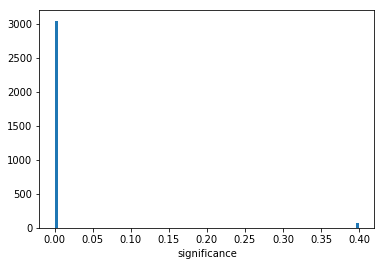

In [29]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

In [30]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

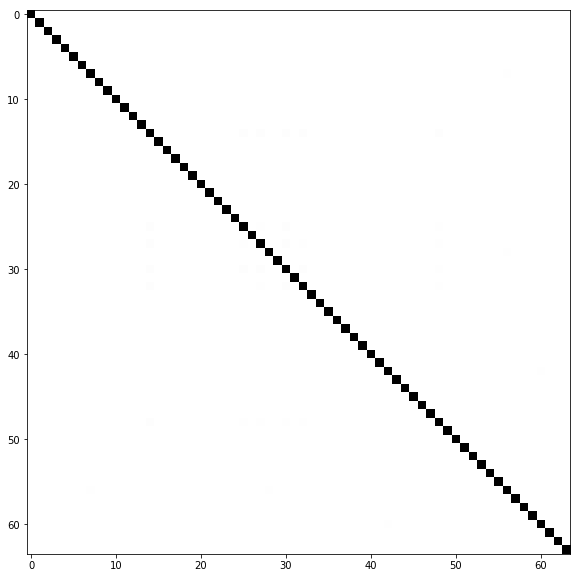

In [31]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [32]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00098351', u'USW00093845', u'USC00098228', u'USC00094429', u'USC00092839', u'US1GALN0001', u'USC00095811', u'USC00090090']


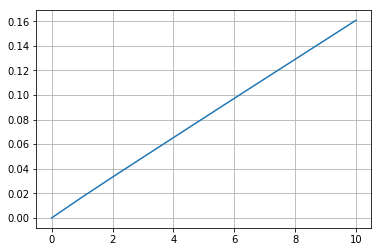

In [33]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [34]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

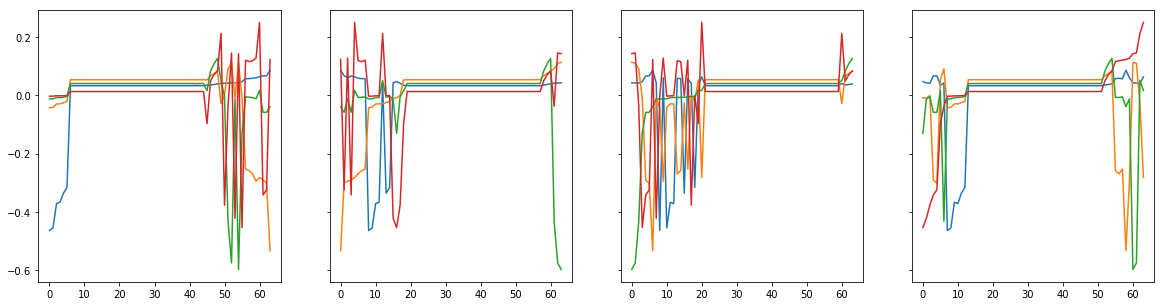

In [35]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [36]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

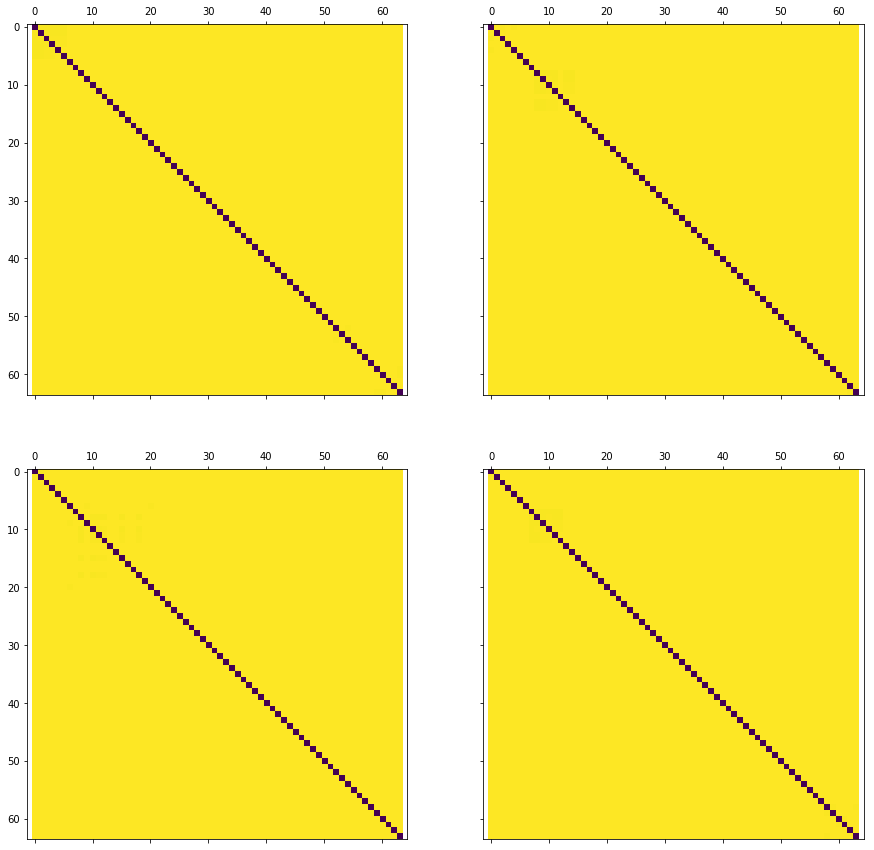

In [37]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [38]:
from pickle import dump
with open(data_dir+'/'+ meas+'_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    